## Ensemble Modeling

We are going to iterate through a collection of Machine Learning Classifiers including Logistic Regression, Random Forest, XGBoost, and CatBoost. We will also iterate through a series of hyperparameters for each model. Both of these steps are to find the optimimal performing model, based on F1 score.

All of this modeling will be done using just the numeric features of our dataset.

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from catboost import CatBoostClassifier
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import label_binarize
from itertools import cycle

import warnings
import os
import time
import math
import requests

import pandas as pd
import numpy as np

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('numeric_df.csv')

In [12]:
df.columns

Index(['home_team_elo', 'away_team_elo', 'home_xG_to_date', 'away_xG_to_date',
       'home_xG_against_to_date', 'away_xG_against_to_date',
       'home_goals_scored_to_date', 'away_goals_scored_to_date',
       'home_goals_conceded_to_date', 'away_goals_conceded_to_date',
       'home_points_to_date', 'away_points_to_date', 'home_form', 'away_form',
       'match_result'],
      dtype='object')

In [9]:

# Split the dataset into features (X) and target (y)
X = df.drop('match_result', axis=1)
y = df['match_result']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# Defining the models and parameter grid
model_params = {
    'LogisticRegression': {
        'model': LogisticRegression(),
        'params': {
            'LogisticRegression__C': [1e-6, 1e-4, 1e-2, 1, 2, 3]
        }
    },
    'RandomForestClassifier': {
        'model': RandomForestClassifier(),
        'params': {
            'RandomForestClassifier__n_estimators': [25, 50, 75],
            'RandomForestClassifier__max_depth': [None, 5, 10]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
        'params': {
            'XGBoost__learning_rate': [0.01, 0.1, 0.5, 1],
            'XGBoost__n_estimators': [100, 200, 300],
            'XGBoost__max_depth': [3, 4, 5, 7]
        }
    },
    'CatBoostClassifier': {
    'model': CatBoostClassifier(verbose=0),  # Set verbose to 0 to prevent lots of output
    'params': {
        'CatBoostClassifier__depth': [4, 6, 8, 10],
        'CatBoostClassifier__learning_rate': [0.01, 0.1, 0.5],
        'CatBoostClassifier__iterations': [100, 200, 300]
    }
}
}

# F1 score as the scoring metric
# If 'match_result' is multi-class, use average='macro' to calculate scores for each label, and find their unweighted mean.
# This does not take label imbalance into account.
f1_scorer = make_scorer(f1_score, average='macro')

# List to store results of GridSearchCV
grid_search_results = []

# Loop through each model and perform grid search
for model_name, mp in model_params.items():
    pipe = Pipeline([('scaler', StandardScaler()), (model_name, mp['model'])])
    clf = GridSearchCV(pipe, mp['params'], cv=5, scoring=f1_scorer, return_train_score=False)
    clf.fit(X_train, y_train)
    grid_search_results.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_,
        'best_estimator': clf.best_estimator_
    })

grid_search_results


[{'model': 'LogisticRegression',
  'best_score': 0.399718514648683,
  'best_params': {'LogisticRegression__C': 2},
  'best_estimator': Pipeline(steps=[('scaler', StandardScaler()),
                  ('LogisticRegression', LogisticRegression(C=2))])},
 {'model': 'RandomForestClassifier',
  'best_score': 0.4341227699740477,
  'best_params': {'RandomForestClassifier__max_depth': None,
   'RandomForestClassifier__n_estimators': 25},
  'best_estimator': Pipeline(steps=[('scaler', StandardScaler()),
                  ('RandomForestClassifier',
                   RandomForestClassifier(n_estimators=25))])},
 {'model': 'XGBoost',
  'best_score': 0.44738501328112357,
  'best_params': {'XGBoost__learning_rate': 0.5,
   'XGBoost__max_depth': 5,
   'XGBoost__n_estimators': 300},
  'best_estimator': Pipeline(steps=[('scaler', StandardScaler()),
                  ('XGBoost',
                   XGBClassifier(base_score=None, booster=None, callbacks=None,
                                 colsample_byl

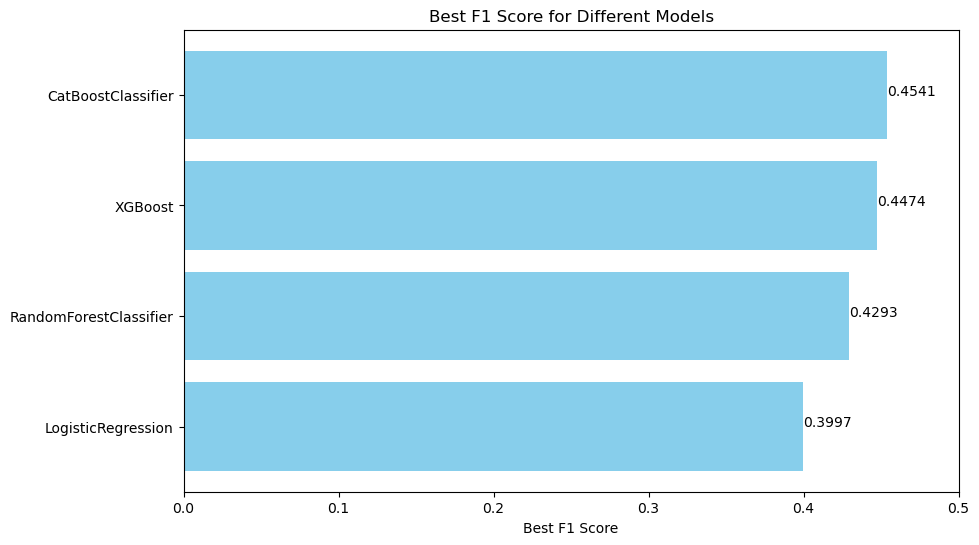

In [10]:
# Results from the hyperparameter tuning
results = [
    {'model': 'LogisticRegression', 'best_score': 0.399718514648683, 'best_params': {'LogisticRegression__C': 2}},
    {'model': 'RandomForestClassifier', 'best_score': 0.42933520693584654, 'best_params': {'RandomForestClassifier__max_depth': None, 'RandomForestClassifier__n_estimators': 50}},
    {'model': 'XGBoost', 'best_score': 0.44738501328112357, 'best_params': {'XGBoost__learning_rate': 0.5, 'XGBoost__max_depth': 5, 'XGBoost__n_estimators': 300}},
    {'model': 'CatBoostClassifier', 'best_score': 0.45408248704088583, 'best_params': {'CatBoostClassifier__depth': 10, 'CatBoostClassifier__iterations': 300, 'CatBoostClassifier__learning_rate': 0.1}}
]

# Extract model names and their best scores
model_names = [r['model'] for r in results]
best_scores = [r['best_score'] for r in results]

# Plotting the results
plt.figure(figsize=(10, 6))
plt.barh(model_names, best_scores, color='skyblue')
plt.xlabel('Best F1 Score')
plt.title('Best F1 Score for Different Models')
plt.xlim(0, 0.5)  # Assuming the F1 scores are between 0 and 0.5
for index, value in enumerate(best_scores):
    plt.text(value, index, str(round(value, 4)))
plt.show()


Above we can see the performance of the optimized models, with CatBoost being the top performer.

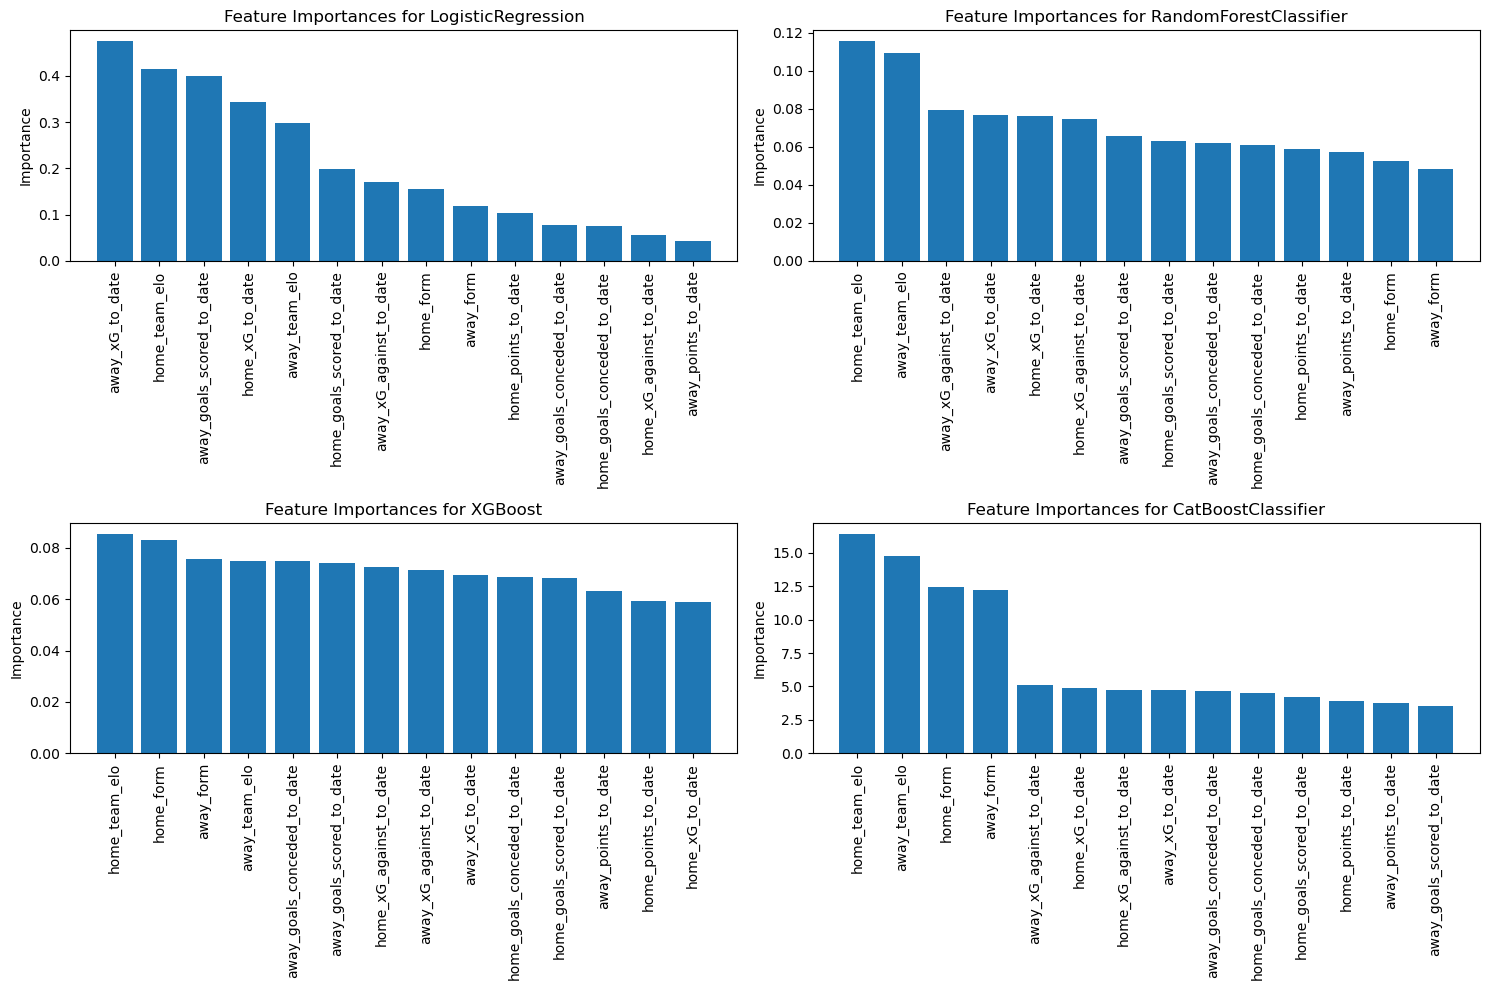

In [11]:


# Assuming 'grid_search_results' is a list of dictionaries with your grid search results
# which includes the best estimator for each model

# Feature names
feature_names = X_train.columns

# Initialize a figure
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes = axes.ravel()

# Loop through each model's best estimator and plot feature importances
for idx, result in enumerate(grid_search_results):
    model_name = result['model']
    best_estimator = result['best_estimator']
    
    # Get feature importances
    if model_name in ['RandomForestClassifier', 'XGBoost']:
        importances = best_estimator.named_steps[model_name].feature_importances_
    elif model_name == 'LogisticRegression':
        # For LogisticRegression, take the absolute value of coefficients as importance
        importances = np.abs(best_estimator.named_steps[model_name].coef_[0])
    elif model_name == 'CatBoostClassifier':
        # For CatBoost, use the get_feature_importance method
        importances = best_estimator.named_steps[model_name].get_feature_importance()
    
    # Sort the feature importances in descending order
    indices = np.argsort(importances)[::-1]
    
    # Plot the feature importances
    ax = axes[idx]
    ax.bar(range(len(importances)), importances[indices], align="center")
    ax.set_xticks(range(len(importances)))
    ax.set_xticklabels(feature_names[indices], rotation=90)
    ax.set_xlim([-1, len(importances)])
    ax.set_title(f'Feature Importances for {model_name}')
    ax.set_ylabel('Importance')

# Adjust layout
plt.tight_layout()
plt.show()
